# Introduction to Arabic Dialect Identification

## Problem Definition

Arabic has a 28-symbol alphabet that can change meaning depending on where it appears in a word. Additionally, Arabic is read from right to left, which is completely counter-intuitive to how most westerners read. The letters and the diacritics, which alter the sound values of the letters to which they are attached, make it a two-dimensional language. Additionally, a word’s meaning might vary depending on its diacritics. All printed materials are written in modern standard Arabic (MSA), which is the official language of all Arab nations. However, each Arabic-speaking country learns a particular dialect of Arabic as its native tongue, which is defined as the linguistic traits of a particular community based on the region, such as Egyptian, Maghrebi, Gulf, etc. Many applications, including sentiment analysis, Arabic speech recognition, E-health chatbots, Machine Translation, etc., can benefit if we can automate a system to detect Arabic dialects accurately.

Reference: https://link.springer.com/chapter/10.1007/978-3-031-21595-7_7

## Dataset

The used dataset on this case study is Arabic Online Commentary(AOC).it was generated by gathering comments from three Arabic news papers publications, each of which represented one of the dialects, Al-Ghad(leventine), Al-Riyadh(Gulf), and Al-Youm Al-sabea(Egyptian).

The dataset was annotated using an annotation interface where random phrases were displayed to the annotator, who had to make two statements about it: first, its dialectal content, such as whether it is mostly dialect, does not have any dialect, or is it mixed; and second, its dialect type, such as Leventine, Egyptian, Gulf, or MSA. As expected, each newspaper contained more comments in the local dialect of the nation in which it was published; yet, MSA predominated in all of them, creating a problem of class imbalance that we concentrated on resolving in our methods. The dataset contains 108,173 K comments.

you could find the paper from here: https://aclanthology.org/P11-2007/


There are other Arabic Dialect(AD) datasets. one of them is NADI2020. 
you could read more about it from here: https://aclanthology.org/2020.wanlp-1.9.pdf
The Dataset Access: https://sites.google.com/view/nadi-shared-task

### Install and Import the Libraries

In [1]:
#!pip install arabic_reshaper
#!pip install python-bidi
#!pip install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper
from wordcloud import WordCloud
import gensim
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

### Read The Data

In [3]:
data=pd.read_csv('Arabic_Data_cleaned_without_duplicated.csv')
data = data.dropna()
data = data.drop(['Unnamed: 0'], axis  =1)
data

,Arabic_Tweets_Cleaned,labels_new
0,اضافه قيام معلمو جيزه ذهاب جريد سابع نشر خبر ا...,MSA
1,بعد الله حرام تجي تلقي واقف اشاره عرض متعدي نا...,MSA
2,لمس يد مرة واضح جد حكم,DIAL_LEV
3,خصوص هاتريك عمر راح صار,DIAL_LEV
4,الله أجبر كسر رجع أدهم قبل بكر,DIAL_GLF
...,...,...
77240,بورسعيد حكاية,DIAL_LEV
77241,نعم لبس زي رسمي سعودي نظر علي اعين,MSA
77242,اتوقع الله اعلم قصد بقي شعب مسافر شل عد لا كلام,DIAL_GLF
77243,يتبدا,DIAL_EGY


In [4]:
text = data['Arabic_Tweets_Cleaned'].values.tolist()
target = data['labels_new'].values.tolist()

data['label_num'] = data['labels_new'].map({'MSA' : 0, 'DIAL_LEV': 1, 'DIAL_GLF': 2, 'DIAL_EGY': 3})


In [5]:
data

,Arabic_Tweets_Cleaned,labels_new,label_num
0,اضافه قيام معلمو جيزه ذهاب جريد سابع نشر خبر ا...,MSA,0
1,بعد الله حرام تجي تلقي واقف اشاره عرض متعدي نا...,MSA,0
2,لمس يد مرة واضح جد حكم,DIAL_LEV,1
3,خصوص هاتريك عمر راح صار,DIAL_LEV,1
4,الله أجبر كسر رجع أدهم قبل بكر,DIAL_GLF,2
...,...,...,...
77240,بورسعيد حكاية,DIAL_LEV,1
77241,نعم لبس زي رسمي سعودي نظر علي اعين,MSA,0
77242,اتوقع الله اعلم قصد بقي شعب مسافر شل عد لا كلام,DIAL_GLF,2
77243,يتبدا,DIAL_EGY,3


### Visualize the Data

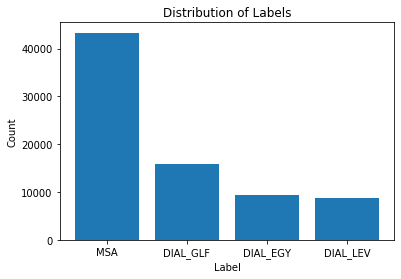

In [6]:

# Extract label column
labels = data['labels_new']

# Count occurrences of each label
label_counts = labels.value_counts()

# Create bar chart
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


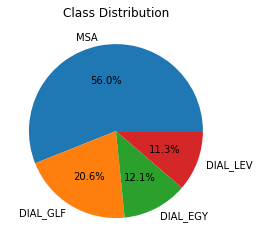

In [7]:
# Create pie chart
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()


In [8]:
#text_cloud 
text_cloud = " ".join(tweet for tweet in text)


In [9]:
text_cloud=arabic_reshaper.reshape(text_cloud)
text_cloud = get_display(text_cloud) 

In [10]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                font_path='arial',
                min_font_size = 10).generate(text) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

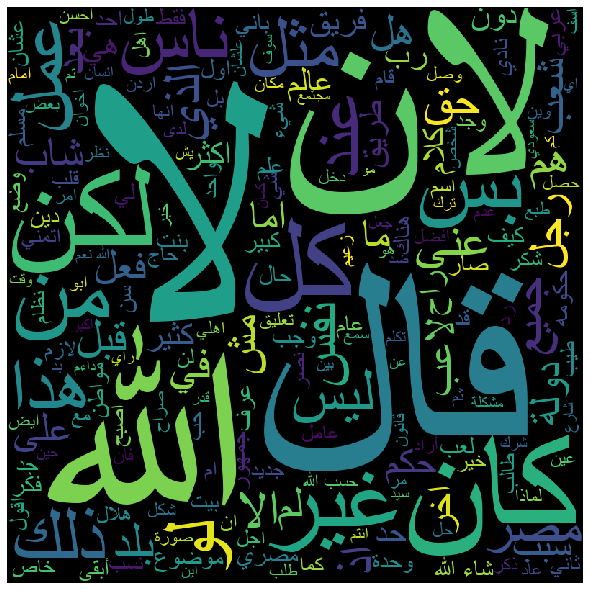

In [11]:
plot_word_cloud(text_cloud) 

### Apply Features Extraction Technique

### TF-IDF 

In [12]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer

# count_vect = CountVectorizer() 
# X_train_counts = count_vect.fit_transform(X_train) 
# X_train_counts2 = count_vect.fit_transform(X_train2) 
# tfidf_transformer = TfidfTransformer()
# X_tfidf_train = tfidf_transformer.fit_transform(X_train_counts)
# X_tfidf_train2 = tfidf_transformer.fit_transform(X_train_counts2)
# X_test_counts = count_vect.transform(X_test) 
# X_tfidf_test = tfidf_transformer.transform(X_test_counts)
# X_test_counts2 = count_vect.transform(X_test2) 
# X_tfidf_test2 = tfidf_transformer.transform(X_test_counts2)

### Aravec

In [13]:
model = gensim.models.Word2Vec.load('C:/Users/Salma/Downloads/NLP/tweet_cbow_100/tweets_cbow_100')

In [14]:
def vectorize(text):
    vectors = []
    tokens = word_tokenize(text)
    for token in tokens:
        try:
            vectors.append(model[token])
        except KeyError:
            continue
    return np.mean(vectors, axis=0)

In [15]:
data['vector'] = data['Arabic_Tweets_Cleaned'].apply(lambda text: vectorize(text))
data

C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,Arabic_Tweets_Cleaned,labels_new,label_num,vector
0,اضافه قيام معلمو جيزه ذهاب جريد سابع نشر خبر ا...,MSA,0,"[0.6215451, 0.69428766, 0.21113762, 0.55404645..."
1,بعد الله حرام تجي تلقي واقف اشاره عرض متعدي نا...,MSA,0,"[1.6746395, -0.6532886, -0.07874295, -0.860425..."
2,لمس يد مرة واضح جد حكم,DIAL_LEV,1,"[1.4305055, -0.03323536, 0.9111163, -0.6217881..."
3,خصوص هاتريك عمر راح صار,DIAL_LEV,1,"[1.2818004, 0.12712921, 0.30036688, -0.5436217..."
4,الله أجبر كسر رجع أدهم قبل بكر,DIAL_GLF,2,"[1.3991146, -1.6648656, 1.3411726, -1.7823987,..."
...,...,...,...,...
77240,بورسعيد حكاية,DIAL_LEV,1,"[0.50899076, -1.8429381, 0.9221798, -0.9520262..."
77241,نعم لبس زي رسمي سعودي نظر علي اعين,MSA,0,"[0.25490046, -0.041345835, 0.3667192, 1.120241..."
77242,اتوقع الله اعلم قصد بقي شعب مسافر شل عد لا كلام,DIAL_GLF,2,"[1.9213687, -0.74619865, 0.11014826, -0.469350..."
77243,يتبدا,DIAL_EGY,3,NaN


In [16]:
data = data.dropna()
data

,Arabic_Tweets_Cleaned,labels_new,label_num,vector
0,اضافه قيام معلمو جيزه ذهاب جريد سابع نشر خبر ا...,MSA,0,"[0.6215451, 0.69428766, 0.21113762, 0.55404645..."
1,بعد الله حرام تجي تلقي واقف اشاره عرض متعدي نا...,MSA,0,"[1.6746395, -0.6532886, -0.07874295, -0.860425..."
2,لمس يد مرة واضح جد حكم,DIAL_LEV,1,"[1.4305055, -0.03323536, 0.9111163, -0.6217881..."
3,خصوص هاتريك عمر راح صار,DIAL_LEV,1,"[1.2818004, 0.12712921, 0.30036688, -0.5436217..."
4,الله أجبر كسر رجع أدهم قبل بكر,DIAL_GLF,2,"[1.3991146, -1.6648656, 1.3411726, -1.7823987,..."
...,...,...,...,...
77239,مهرجان انتهي مغلق موجود رياض ممشي ملك عبدالله ...,MSA,0,"[1.5246263, -0.48796833, 0.846, 0.31807435, 0...."
77240,بورسعيد حكاية,DIAL_LEV,1,"[0.50899076, -1.8429381, 0.9221798, -0.9520262..."
77241,نعم لبس زي رسمي سعودي نظر علي اعين,MSA,0,"[0.25490046, -0.041345835, 0.3667192, 1.120241..."
77242,اتوقع الله اعلم قصد بقي شعب مسافر شل عد لا كلام,DIAL_GLF,2,"[1.9213687, -0.74619865, 0.11014826, -0.469350..."


### Split The Data into Train and Test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data.vector.values ,
                                                    data.label_num,
                                                    test_size=0.2, 
                                                    shuffle = True,  
                                                    random_state=42)

In [18]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (61394,)
Shape of X_test before reshaping:  (15349,)
Shape of X_train after reshaping:  (61394, 100)
Shape of X_test after reshaping:  (15349, 100)


## Text Classification Algorithms

Choosing the best classifier for a particular task can depend on a variety of factors, including:

- **Size and quality of the training data:** Different classifiers may perform better or worse depending on the size and quality of the training data. For example, deep learning models typically require large amounts of high-quality training data to perform well, while simpler models like Naive Bayes can work well even with smaller datasets.

- **Complexity of the problem:** Some problems may be more complex than others, and may require more sophisticated models to solve effectively. For example, problems with complex interactions between variables may require models like decision trees or random forests, while problems with a large number of features may require dimensionality reduction techniques.

- **Interpretability of the model:** In some cases, it may be important to have a model that is easy to interpret and understand, particularly if the model's output will be used to make important decisions. In such cases, simpler models like Naive Bayes or logistic regression may be preferred over more complex models like deep neural networks.

- **Performance metrics:** Different classifiers may perform differently on different metrics, depending on the task at hand. For example, precision and recall may be more important than accuracy for a binary classification problem with imbalanced classes. It is important to choose a classifier that performs well on the metrics that are most important for the task.

- **Time and resource constraints:** Some models may be more computationally expensive than others, and may require more time and resources to train and evaluate. It is important to choose a model that can be trained and evaluated within the available time and resource constraints.

## Naive Bayes

A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem.

$$ P(c | d) = \frac{P(c) P(d | c)}{P(d)} $$

where:

- $P(c | d)$ is the posterior probability of the class given the document,
- $P(c)$ is the prior probability of the class,
- $P(d | c)$ is the likelihood of the document given the class,
- and $P(d)$ is the probability of the document.


Types of Naive Bayes Classifier:
- **Multinomial Naive Bayes:**
This is mostly used for document classification problem, i.e whether a document belongs to the category of sports, politics, technology etc. The features/predictors used by the classifier are the frequency of the words present in the document.

- **Gaussian Naive Bayes:**
When the predictors take up a continuous value and are not discrete, we assume that these values are sampled from a gaussian distribution.

- **Complement Naive Bayes**: is particularly suited to work with imbalanced datasets. In complement Naive Bayes, instead of calculating the probability of an item belonging to a certain class, we calculate the probability of the item belonging to all the classes. This is the literal meaning of the word, complement and hence is called Complement Naive Bayes.

### Multinomial Naive Bayes classifier

MinMaxScaler is a normalization technique that scales the data between 0 and 1. It can help to ensure that each feature is on the same scale and prevents one feature from dominating the others. This can sometimes lead to improved performance, particularly if the dataset has features with different scales or units.

In [19]:
from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
X_train_nor = scaler.fit_transform(X_train_2d)
X_test_nor = scaler.transform(X_test_2d)

In [20]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_nor, y_train)

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
predicted = clf.predict(X_test_nor)

precision = accuracy_score(predicted, y_test) * 100
print("Accuracy with Multinomial Naive Bayes: {0:.6f}".format(precision))

Accuracy with Multinomial Naive Bayes: 56.205616


In [22]:
from sklearn.metrics import f1_score
f = f1_score(y_test, predicted, average='weighted')
print("F1-score with Multinomial Naive Bayes: {0:.6f}".format(f))

F1-score with Multinomial Naive Bayes: 0.404476


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

           0       0.56      1.00      0.72      8627
           1       0.00      0.00      0.00      1670
           2       0.00      0.00      0.00      3230
           3       0.00      0.00      0.00      1822

    accuracy                           0.56     15349
   macro avg       0.14      0.25      0.18     15349
weighted avg       0.32      0.56      0.40     15349



C:\Users\Salma\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Salma\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Salma\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Predict the Dialect of the Entered sentence
sentence = 'ياخي شلون تبي تحقق مونديال وانت بدونه ضايع'

#X_testing_counts = count_vect.transform(sentence) 
#X_tfidf_testing = tfidf_transformer.transform(X_testing_counts)
X_testing = vectorize(sentence).reshape(1,-1)
clf.predict(X_testing)

C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([2], dtype=int64)

## Gaussian Naive Bayes

To check if the Data Features are follows the Gaussian Distribution we could plot each feature distribution

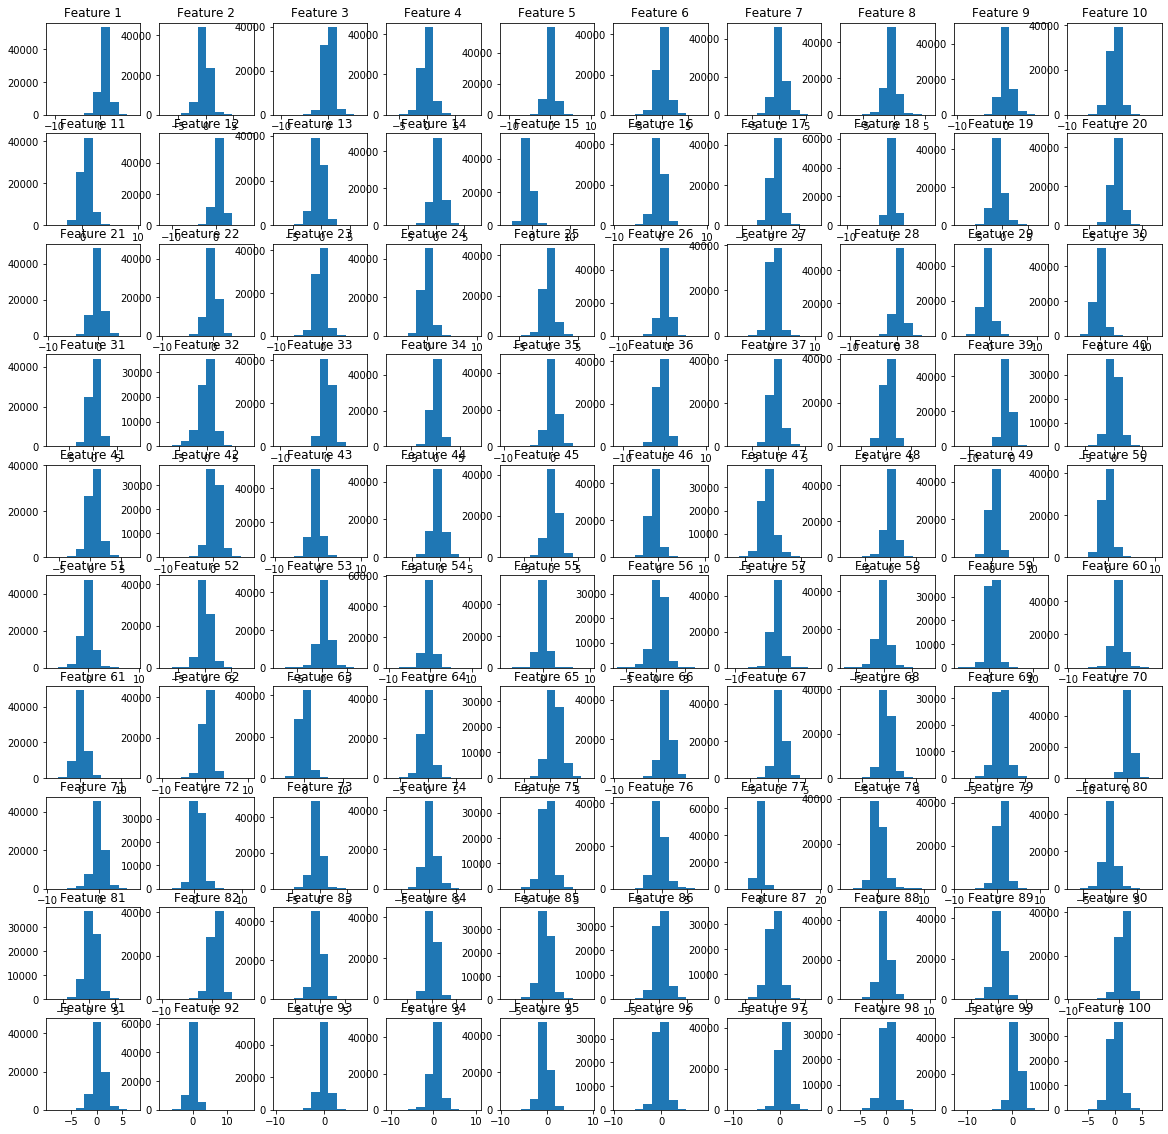

In [25]:
# extract the feature vector column
features = data['vector']

# plot the distribution of each feature using a histogram
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        axs[i, j].hist(features.apply(lambda x: x[i*10+j]))
        axs[i, j].set_title(f'Feature {i*10+j+1}')
plt.show()


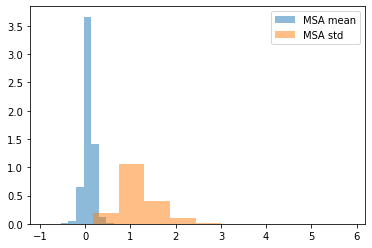

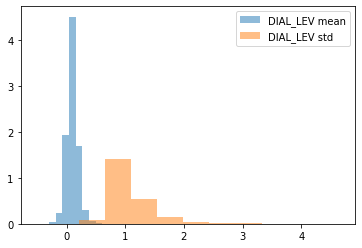

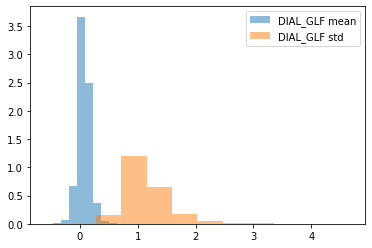

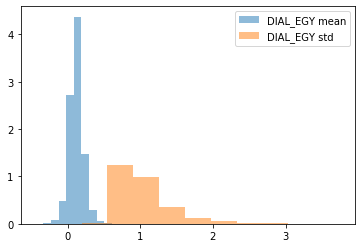

In [26]:
from scipy.stats import norm


# plot histograms for each class
for cls in data['labels_new'].unique():
    plt.hist(data[data['labels_new']==cls]['vector'].apply(lambda x: x.mean()), density=True, alpha=0.5, label=cls+' mean')
    plt.hist(data[data['labels_new']==cls]['vector'].apply(lambda x: x.std()), density=True, alpha=0.5, label=cls+' std')
    plt.legend()
    plt.show()


In [27]:
from sklearn.naive_bayes import GaussianNB
GNBclf = GaussianNB().fit(X_train_2d, y_train)

In [28]:
GNpredicted = GNBclf.predict(X_test_2d)
GNtrain = GNBclf.predict(X_train_2d)
precision = accuracy_score(GNpredicted, y_test) * 100
print("Accuracy with Gaussian Naive Bayes: {0:.6f}".format(precision))

Accuracy with Gaussian Naive Bayes: 51.710209


In [29]:
f = f1_score(y_test, GNpredicted, average='weighted')
print("F1-score with Gaussian Naive Bayes: {0:.6f}".format(f))

F1-score with Gaussian Naive Bayes: 0.545716


In [30]:
print(classification_report(y_test,GNpredicted))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68      8627
           1       0.18      0.43      0.25      1670
           2       0.50      0.30      0.38      3230
           3       0.38      0.70      0.49      1822

    accuracy                           0.52     15349
   macro avg       0.47      0.50      0.45     15349
weighted avg       0.63      0.52      0.55     15349



In [31]:
Sentences = ["ليه بتقول كده علينا طيب يعم انت مالك اصلا؟", "ياليت والله علشان  يريحنا", "ياخي شلون تبي تحقق مونديال وانت بدونه ضايع"]
for sentence in Sentences:
    
    X_testing = vectorize(sentence).reshape(1,-1)
    print("The prediction:", GNBclf.predict(X_testing) )


The prediction: [3]
The prediction: [2]
The prediction: [2]


C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Complement Naive Bayes

In [32]:
from sklearn.naive_bayes import ComplementNB
complementclf = ComplementNB().fit(X_train_nor, y_train)

In [33]:
complementpredicted = complementclf.predict(X_test_nor)

precision = accuracy_score(complementpredicted, y_test) * 100
print("Accuracy with complement Naive Bayes: {0:.6f}".format(precision))

Accuracy with complement Naive Bayes: 65.913089


In [34]:
print(classification_report(y_test,complementpredicted))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      8627
           1       0.32      0.02      0.03      1670
           2       0.49      0.60      0.54      3230
           3       0.52      0.52      0.52      1822

    accuracy                           0.66     15349
   macro avg       0.52      0.49      0.47     15349
weighted avg       0.63      0.66      0.63     15349



In [35]:
Sentences = ["ليه بتقول كده علينا طيب يعم انت مالك اصلا؟", "ياليت والله علشان  يريحنا", "ياخي شلون تبي تحقق مونديال وانت بدونه ضايع", "ماذا حدث هنا؟"]
for sentence in Sentences:
    
    X_testing = vectorize(sentence).reshape(1,-1)
    print("The prediction:", complementclf.predict(X_testing) )

The prediction: [3]
The prediction: [2]
The prediction: [2]
The prediction: [0]


C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


**Complement Naive Bayes** outperforms both **Gaussian Naive Bayes** and **Multinomial Naive Bayes** in text classification tasks.

Strengths Points of Naive Bayes:

- Fast and simple: Naive Bayes is a relatively simple and fast algorithm compared to other more complex models, such as deep learning models.

- Scalability: Naive Bayes can scale well to large datasets, making it suitable for problems with high-dimensional data.

- Robustness to irrelevant features: Naive Bayes can handle irrelevant features well, as it makes the assumption that all features are independent of each other.

- Good performance in certain domains: Naive Bayes has been shown to perform well in certain domains, such as text classification, spam filtering, and sentiment analysis.

Weaknesses Points of Naive Bayes:

- Assumption of independence: The "naive" assumption that Naive Bayes makes, that all features are independent of each other, is often not true in practice. This can lead to decreased accuracy in some cases.

- Limited expressiveness: Naive Bayes can only model linear decision boundaries, which can limit its ability to capture more complex relationships between features.

- Sensitivity to data quality: Naive Bayes can be sensitive to the quality of the training data, particularly if there are missing values or outliers.

- Limited ability to handle continuous features: Naive Bayes assumes that all features are categorical, and can struggle to handle continuous features without discretization.

### Support Vector Machine

It is a machine learning algorithm used for both classification and regression tasks. It is a supervised learning algorithm that works by finding the best hyperplane that separates the data into different classes. In other words, SVM tries to find the decision boundary that maximizes the margin between the two classes.

![Example Image](svm1.png "Optional Title")

In [36]:
%%time
from sklearn import svm
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train_2d, y_train)

Wall time: 10min 20s


In [37]:
test_predictions = svm_clf.predict(X_test_2d)

In [38]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM: {0:.6f}".format(precision))

Accuracy with SVM: 75.346928


In [39]:
print(classification_report(y_test,test_predictions))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      8627
           1       0.74      0.39      0.51      1670
           2       0.71      0.55      0.62      3230
           3       0.77      0.56      0.65      1822

    accuracy                           0.75     15349
   macro avg       0.75      0.61      0.66     15349
weighted avg       0.75      0.75      0.74     15349



In [40]:
Sentences = ["ساعتين جد وكوباية شاي والمنهج ده هجيبه في شوال يابني انت والله متقلقش",
             "طب ايش هو الخلاف بالتحديد حتي يصير كل هالعقوبه", "اللهم أعننا علي ذكرك وشكرك وحسن عبادتك",
             "هي المشرحة ناقصه قتله  فكك مننا وروح شوف بلد تانيه تصيع فيها يابني انت ",
             "وي يا علي وي وي يا علي ويي وي وي وي القاضييييه ممكن علييي معلولل  لا لا هذا ولدنا افشه محمد مجدي قفشه"]

In [41]:
for sentence in Sentences:
    
    X_testing = vectorize(sentence).reshape(1,-1)
    print(svm_clf.predict(X_testing))

[3]
[1]
[0]
[3]
[2]


C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Salma\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


The main advantage of SVM over other classification algorithms is that it can handle high-dimensional data and can work well even when the number of features is much greater than the number of samples. SVM can also handle non-linearly separable data by transforming the data into a higher-dimensional space using a kernel function.

## Logistic Regression

logistic regression is one of the most important analytic tools in natural language processing, logistic regression is the baseline supervised machine learning algorithm for classification, and also has a very close relationship with neural networks. a neural network can be viewed as a series of logistic regression classifiers stacked on top of each other.

The advantages of logistic regression include its simplicity, interpretability, and efficiency in training and predicting on large datasets. It can also handle both binary and multi-class classification problems.

The main components of logistic regression are:

- Input Features: These are the independent variables or features of the dataset that are used to predict the dependent variable. 

- Sigmoid Function: The sigmoid function is used to transform the output of the linear regression model into a probability score between 0 and 1. It maps any input value to a value between 0 and 1.

$$f(x) = \frac{1}{1 + e^{-x}}$$

where $x$ is the input value.

- Loss Function: The loss function is used to calculate the difference between the predicted probability and the actual label.

$$J(w) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)}\log(h_w(x^{(i)})) + (1-y^{(i)})\log(1-h_w(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}w_j^2$$

where $m$ is the number of training examples, $y^{(i)}$ is the true label of the $i$-th example, $x^{(i)}$ is the $i$-th example, and $h_{\theta}(x^{(i)})$ is the predicted probability that $y^{(i)}=1$ given the input $x^{(i)}$ and the model parameters $\theta$

- Optimization Algorithm: The optimization algorithm is used to minimize the loss function and adjust the weights or coefficients to improve the accuracy of the model.


In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=10000, solver= 'saga', penalty = 'L1')
lr = lr.fit(X_train_2d, y_train)

The solver in logistic regression refers to the algorithm used to find the optimal weights (parameters) for the model. The choice of solver determines how the optimization problem is solved and can affect the speed and accuracy of the model. There are several solvers available in scikit-learn, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, and ‘saga’.

In [43]:
lr_predictions = lr.predict(X_test_2d)

In [44]:
print(classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      8627
           1       0.60      0.27      0.37      1670
           2       0.63      0.48      0.55      3230
           3       0.67      0.49      0.57      1822

    accuracy                           0.70     15349
   macro avg       0.65      0.54      0.57     15349
weighted avg       0.68      0.70      0.67     15349



<font color='red'>Why The SVM outperformed the Logistic regression model? </font>


One of the main advantages of logistic regression is that it is easy to implement and interpret. It is also a very efficient algorithm that can work well on small and large datasets. It is also robust to noise and can handle missing values. Moreover, it is a linear model which makes it computationally efficient and easy to scale up. Additionally, logistic regression outputs probabilities which can be useful for ranking predictions based on their confidence levels.

## Decision Surface plotting for the Classifiers

The decision surface is the boundary that separates different classes in a classification problem. It is a graphical representation of the model's decision-making process.

### Plot the Data Features after applying PCA

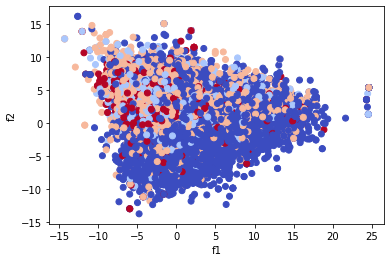

In [58]:
from sklearn.decomposition import PCA

pca_reduction = PCA(n_components=2)
X_pca2 = pca_reduction.fit_transform(X_train_2d)

# Plot transformed data in 2D
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_train, cmap = plt.cm.coolwarm)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

In [45]:
def plot_decision_surface(model, X, y, cmap= plt.cm.coolwarm):
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    ax = plt.gca()
    ax.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap = cmap)
    x0_lim = ax.get_xlim()
    x1_lim = ax.get_ylim()
    
    x0, x1 = np.meshgrid(np.linspace(*x0_lim, 500), np.linspace(*x1_lim, 500))
    f0, f1 = x0.flatten(), x1.flatten()
    f0, f1 = f0.reshape((len(f0), 1)), f1.reshape((len(f1), 1))
    
    X_test = np.hstack((f0, f1))
    model.fit(X_pca, y)
        
    y_pred = model.predict(X_test)
   # print("Training accuracy:", 100 * accuracy_score(y_pred, y))
    
    z = y_pred.reshape(x0.shape)
    
    n_classes = len(np.unique(y_pred))
    ax.contourf(x0, x1, z, levels= np.arange(n_classes + 1) - 0.5, alpha = 0.5, cmap = cmap)
    
    ax.set_xlabel("Feature 0")
    ax.set_xlabel("Feature 1")
    plt.show()    

In [46]:
model_dict = {"SVM": svm.SVC(),
              "Logistic Regression": LogisticRegression(),
              "Gaussian Naive Bayes": GaussianNB()
}

Model: SVM


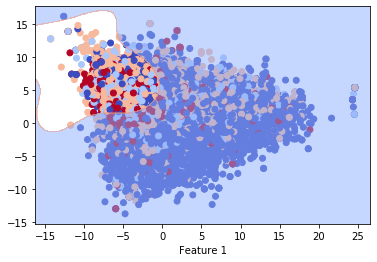

Model: Logistic Regression


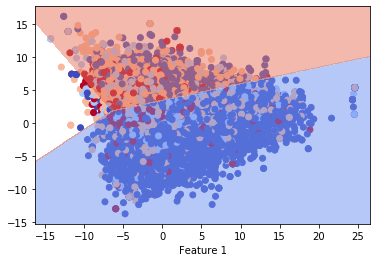

Model: Gaussian Naive Bayes


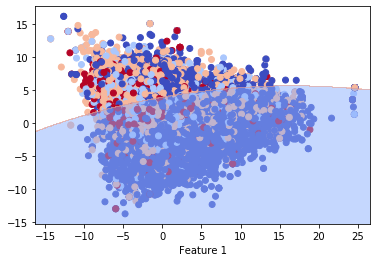

In [47]:
for model_name, model in model_dict.items():
    print("Model:", model_name)
    plot_decision_surface(model, X_train_2d, y_train)

By analyzing the decision surface, we can gain insights into the following aspects of the model:

- Model complexity: The shape and smoothness of the decision surface can provide information on the complexity of the model. A simple decision surface may indicate a simpler model, while a more complex decision surface may indicate a more complex model.

- Overfitting/Underfitting: The decision surface can help us identify whether the model is overfitting or underfitting the data. If the decision surface follows the training data too closely, the model may be overfitting. If the decision surface is too simple and fails to capture the complexity of the data, the model may be underfitting.

- Feature importance: The decision surface can show which features are important for the classification task. Features that are closer to the decision boundary may be more important for the classification task.

- Model performance: The decision surface can give an indication of the model's performance. A smooth and well-defined decision surface may indicate a model with high accuracy, while a rough or inconsistent decision surface may indicate a model with poor performance.

## Ensemble Learning Techniques

Ensemble learning is a machine learning technique where multiple models are trained and combined to improve the overall predictive performance of the system.

![Example Image](ensemble2.ppm "Optional Title")


1- **Bagging**: This technique involves training multiple models independently on different subsets of the training data, and then aggregating their predictions using a voting or averaging scheme. The most commonly used algorithm for bagging is **Random Forest**.

Random Forest is a powerful ensemble learning algorithm that combines multiple decision trees to improve the accuracy, robustness, and feature importance of the model. It is a low variance algorithm that is less prone to overfitting and can handle noisy, missing, and large-scale data. Random Forest can also provide an estimate of the importance of each feature in the data, which can be useful for feature selection and data analysis.

In [48]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate a Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_train_2d, y_train)

# Make predictions on test data
y_pred = rfc.predict(X_test_2d)

In [49]:
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forest: {0:.6f}".format(precision))

Accuracy with Random Forest: 69.809108


In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81      8627
           1       0.69      0.19      0.30      1670
           2       0.62      0.44      0.51      3230
           3       0.76      0.45      0.57      1822

    accuracy                           0.70     15349
   macro avg       0.69      0.51      0.55     15349
weighted avg       0.69      0.70      0.66     15349



2- **Boosting**: This technique involves training multiple models sequentially, where each subsequent model tries to correct the errors made by the previous models. The most commonly used algorithm for boosting is **Gradient Boosting**.

In Gradient Boosting, weak models, typically decision trees, are trained in a sequential manner where each model is trained to correct the errors of the previous model. The idea is to create a sequence of models that can learn from each other and produce better and better results.

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate a Gradient Boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

# Train the model
gbc.fit(X_train_2d, y_train)

# Make predictions on test data
y_pred = gbc.predict(X_test_2d)


In [52]:
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with Gradient Boosting: {0:.6f}".format(precision))

Accuracy with Gradient Boosting: 70.903642


In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      8627
           1       0.53      0.39      0.45      1670
           2       0.61      0.53      0.56      3230
           3       0.65      0.55      0.60      1822

    accuracy                           0.71     15349
   macro avg       0.64      0.58      0.61     15349
weighted avg       0.70      0.71      0.70     15349



3- **Stacking**: This technique involves training multiple models independently, and then training a meta-model to combine their predictions. The meta-model takes the predictions of the base models as input features and learns how to combine them to make the final prediction. The most commonly used algorithm for stacking is **Stacked Generalization**.

In stacking, the predictions of multiple base classifiers are combined using a meta-classifier. Instead of assigning a class label based on the output of a single classifier, the meta-classifier uses the outputs of several base classifiers as inputs to make a final prediction.

In [54]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Instantiate base models
nb = ComplementNB()
lr = LogisticRegression(random_state=42 , max_iter=10000)


# Instantiate a meta-model
svc = svm.SVC(kernel='linear', random_state=42) 

# Instantiate a StackingClassifier
sc = StackingClassifier(estimators=[('lr', lr), ('nb', nb)], final_estimator=svc)

# Train the model
sc.fit(X_train_nor, y_train)

# Make predictions on test data
y_pred = sc.predict(X_test_nor)


In [55]:
precision = accuracy_score(y_pred, y_test) * 100
print("Accuracy with Stacking Generalization: {0:.6f}".format(precision))

Accuracy with Stacking Generalization: 69.385628


In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      8627
           1       0.55      0.30      0.39      1670
           2       0.65      0.48      0.55      3230
           3       0.65      0.50      0.56      1822

    accuracy                           0.69     15349
   macro avg       0.64      0.54      0.58     15349
weighted avg       0.68      0.69      0.67     15349



## Conclusion

Random Forest is known for its ability to handle high-dimensional data and non-linear relationships. Gradient Boosting is known for its strong predictive power and ability to handle various types of data. Stacking is known for its flexibility and ability to combine multiple types of classifiers.

There are a few possible reasons why SVM may outperform ensemble learning in certain cases:

- Data distribution: SVM is particularly effective when the data is well-separated and has a clear boundary between classes. In contrast, ensemble learning can be more effective when there is more overlap or ambiguity in the data distribution.

- Noise and outliers: SVM can be sensitive to noise and outliers in the data, whereas ensemble learning can be more robust to such issues.

- Complexity of the model: Ensemble learning involves combining multiple models, which can lead to a more complex and potentially overfitting model. SVM, on the other hand, tends to be a simpler and more straightforward model.

- Size of the dataset: SVM can be particularly effective on small to medium-sized datasets, where the computational cost is not too high. Ensemble learning, on the other hand, can be more effective on larger datasets where the model needs to generalize well to new data.

SVM may perform better than logistic regression due to its ability to handle complex, non-linear relationships between the features and the target variable. SVM can also handle high-dimensional data well, making it a good choice for problems with many features.

On the other hand, logistic regression can be easier to interpret and implement, especially for problems with a small number of features. It can also handle noisy data and outliers well.

the effectiveness of a particular machine learning algorithm depends on many factors, including the specific problem, the data, and the modeling choices. It is often useful to try out multiple algorithms and compare their performance on the same dataset to determine which one works best for a given problem but knowing these factors may help you to choose what models to experiment.

## References

- https://www.geeksforgeeks.org/naive-bayes-classifiers/
- https://www.codingame.com/playgrounds/6734/machine-learning-with-java---part-5-naive-bayes
- https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a
- https://www.geeksforgeeks.org/applying-multinomial-naive-bayes-to-nlp-problems/?ref=rp
- https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
https://medium.com/@eiki1212/natural-language-processing-naive-bayes-classification-in-python-e934365cf40c
- https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
- https://www.geeksforgeeks.org/complement-naive-bayes-cnb-algorithm/
- https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
- https://www.varsitytutors.com/hotmath/hotmath_help/topics/normal-distribution-of-data#:~:text=The%20shape%20of%20a%20normal,the%20standard%20deviation%20is%20large.
- https://www.javatpoint.com/complement-naive-bayes-algorithm#:~:text=In%20Complement%20Naive%20Bayes%2C%20instead,to%20as%20Complement%20Naive%20Bayes.
- https://monkeylearn.com/text-classification-support-vector-machines-svm/
- https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
- https://www.baeldung.com/cs/naive-bayes-vs-svm
- https://towardsdatascience.com/sentiment-analysis-using-logistic-regression-and-naive-bayes-16b806eb4c4b
- https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/
- https://web.stanford.edu/~jurafsky/slp3/5.pdf
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2
- https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/
- https://towardsdatascience.com/ensemble-learning-bagging-boosting-3098079e5422
- https://aclanthology.org/2020.wanlp-1.33.pdf
- https://machinelearningmastery.com/plot-a-decision-surface-for-machine-learning/

## Task 03


After we've applied preprocessing in Task 01 and we converted the text to vector embeddings in Task 02, in this task we need to experiment different models to find the best results. 

Step 1: choose the best preprocessing library you've applied in Task 1

Step 2: Choose the best embedding technique you've applied in Task 2

Step 3: Apply different models (mentioned in this lecture or the next lecture) on the word vectors and evaluate them to get the best performance and results. and put this comparison study in the report with mentioning why you've used these models.

note that: you will use the same dataset from task 1 and task 2

Deliverables:

- the code file as HTML
- The report file as PDF

<font color='red'>The deadline for submitting the task is 4/22/2023 </font>

